- 선택 종목 알맞는 K 값 찾는 볼랜드 밴드 전략 수익률 백테스팅
- 종목 자유 선택
- 매매 방식 
  + 매도 : 상단 돌파, 매수 : 하단 돌파, 나머진 보유
- 전략 적용과 단순 보유 수익 차이

In [230]:
import pandas as pd


In [231]:
from pykrx import stock
stock_df = stock.get_market_ohlcv_by_date('20000101','20191231','035420') # 네이버
# stock_df = stock.get_market_ohlcv_by_date('20210630','20221030','035420') # 네이버
stock_df_close = stock_df[['종가']]
stock_df_close.head()

,종가
날짜,
2002-10-29,2312
2002-10-30,2588
2002-10-31,2459
2002-11-01,2305
2002-11-04,2191


In [232]:
stock_df_close['중심선'] = stock_df_close['종가'].rolling(window=14).mean()

/tmp/ipykernel_31568/1920385813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['중심선'] = stock_df_close['종가'].rolling(window=14).mean()


In [233]:
stock_df_close[19:25]

,종가,중심선
날짜,,
2002-11-25,2138,2065.000000
2002-11-26,2102,2062.214286
2002-11-27,1979,2050.571429
2002-11-28,2070,2048.285714
2002-11-29,2316,2059.928571
2002-12-02,2379,2084.357143


In [234]:
K = 2
std_deviation = stock_df_close['종가'].rolling(window=14).std()
stock_df_close['상단선'] = stock_df_close['중심선'] + K * std_deviation
stock_df_close['하단선'] = stock_df_close['중심선'] - K * std_deviation


/tmp/ipykernel_31568/930140954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['상단선'] = stock_df_close['중심선'] + K * std_deviation
/tmp/ipykernel_31568/930140954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['하단선'] = stock_df_close['중심선'] - K * std_deviation


In [235]:
def calc(closes, highs, lows):
    result = []
    current_state = False  # 초기 상태는 False
    
    for close, high, low in zip(closes, highs, lows):
        if current_state:  # True 상태일 때
            if close >= high:  # 70 이상이면 False로 전환
                current_state = False
        else:  # False 상태일 때
            if close <= low:  # 30 이하면 True로 전환
                current_state = True
        
        result.append(current_state)
    
    return result

In [236]:
stock_df_close['bool'] = calc(stock_df_close['종가'],stock_df_close['상단선'],stock_df_close['하단선'])
stock_df_close['bool'][:-300]

/tmp/ipykernel_31568/270683272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['bool'] = calc(stock_df_close['종가'],stock_df_close['상단선'],stock_df_close['하단선'])


날짜
2002-10-29    False
2002-10-30    False
2002-10-31    False
2002-11-01    False
2002-11-04    False
              ...  
2018-10-05     True
2018-10-08     True
2018-10-10     True
2018-10-11     True
2018-10-12     True
Name: bool, Length: 3948, dtype: bool

In [237]:
stock_df_close['전일종가'] = stock_df_close['종가'].shift(periods=1)

In [238]:
import numpy as np

In [239]:
def calc_returns(closes, bool_signal):
    result = np.ones(len(closes))
    position = False
    entry_price = None
    
    for i in range(1, len(closes)):
        if bool_signal[i] and not position:  # 새로운 매수 시그널
            position = True
            entry_price = closes[i]
        elif not bool_signal[i] and position:  # 매도 시그널
            position = False
            # 매수가 대비 매도가의 수익률 계산
            result[i] = closes[i] / entry_price
            entry_price = None
        elif position:  # 포지션 유지 중
            result[i] = closes[i] / entry_price
    
    return result

In [240]:
# 수정된 수익률 계산
stock_df_close['수익률'] = calc_returns(stock_df_close['종가'].values, stock_df_close['bool'].values)
stock_df_close['누적수익률'] = stock_df_close['수익률'].cumprod()

# CAGR 계산
delta_days = stock_df_close.index[-1] - stock_df_close.index[0]
year = delta_days.days / 365
CAGR = (stock_df_close['누적수익률'].iloc[-1] ** (1/year)) - 1
CAGR

-0.967224764444523

In [241]:
# delta_days = stock_df_close.index[-1] - stock_df_close.index[0]
# year = delta_days.days / 365

# stock_df_close['수익률'] = np.where(stock_df_close['bool'], stock_df_close['종가'] / stock_df_close['전일종가'], 1)
# stock_df_close['누적수익률'] = stock_df_close['수익률'].cumprod()
# CAGR = stock_df_close['누적수익률'].iloc[-1] ** (1/year) -1
# CAGR


In [242]:
simple_rate_of_return = stock_df_close['종가'].iloc[-1] / stock_df_close['종가'].iloc[0]
simple_cum_rate_of_return = 1 * simple_rate_of_return
CAGR = ((simple_cum_rate_of_return ** (1/year))-1) * 100
CAGR

29.11534770749984

In [243]:
stock_df_close.tail()

,종가,중심선,상단선,하단선,bool,전일종가,수익률,누적수익률
날짜,,,,,,,,
2019-12-23,184000,177035.714286,184825.888429,169245.540142,False,183500.0,1.0,3.132255e-26
2019-12-24,182000,177571.428571,185637.093148,169505.763995,False,184000.0,1.0,3.132255e-26
2019-12-26,180500,178285.714286,185364.548237,171206.880334,False,182000.0,1.0,3.132255e-26
2019-12-27,183500,178964.285714,186094.549338,171834.022091,False,180500.0,1.0,3.132255e-26
2019-12-30,186500,179785.714286,187568.479127,172002.949445,False,183500.0,1.0,3.132255e-26


### Chart 작성

In [244]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

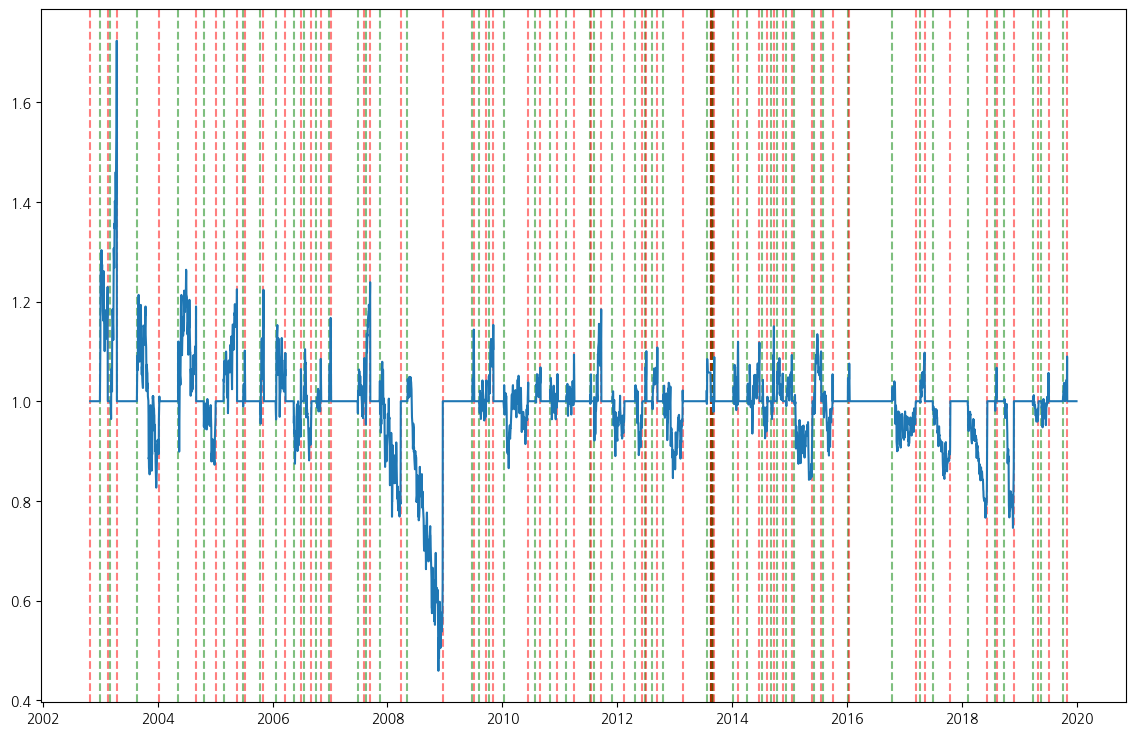

In [249]:
plt.figure(figsize=(14,9), dpi=100) #  stock_df_close['수익률']
# plt.plot(stock_df_close['종가'][14:300]/10000)
# plt.plot(stock_df_close['RSI'][14:300])
# Boolean 시리즈의 상태 변화 지점 찾기
bool_series = stock_df_close['bool'][:]
changes = bool_series.ne(bool_series.shift()).astype(int)  # 이전 값과 다른 지점 찾기
change_points = bool_series.index[changes == 1]  # 변화가 있는 지점의 인덱스

# 상태 변화 지점에 세로선 그리기
for idx in change_points:
    if bool_series[idx]:  # True로 변하는 지점
        plt.axvline(x=idx, color='g', linestyle='--', alpha=0.5, label='매수 시점' if '매수 시점' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:  # False로 변하는 지점
        plt.axvline(x=idx, color='r', linestyle='--', alpha=0.5, label='매도 시점' if '매도 시점' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.plot(stock_df_close['수익률'][:])
# plt.plot(stock_df_close['누적수익률'][:])
plt.show()

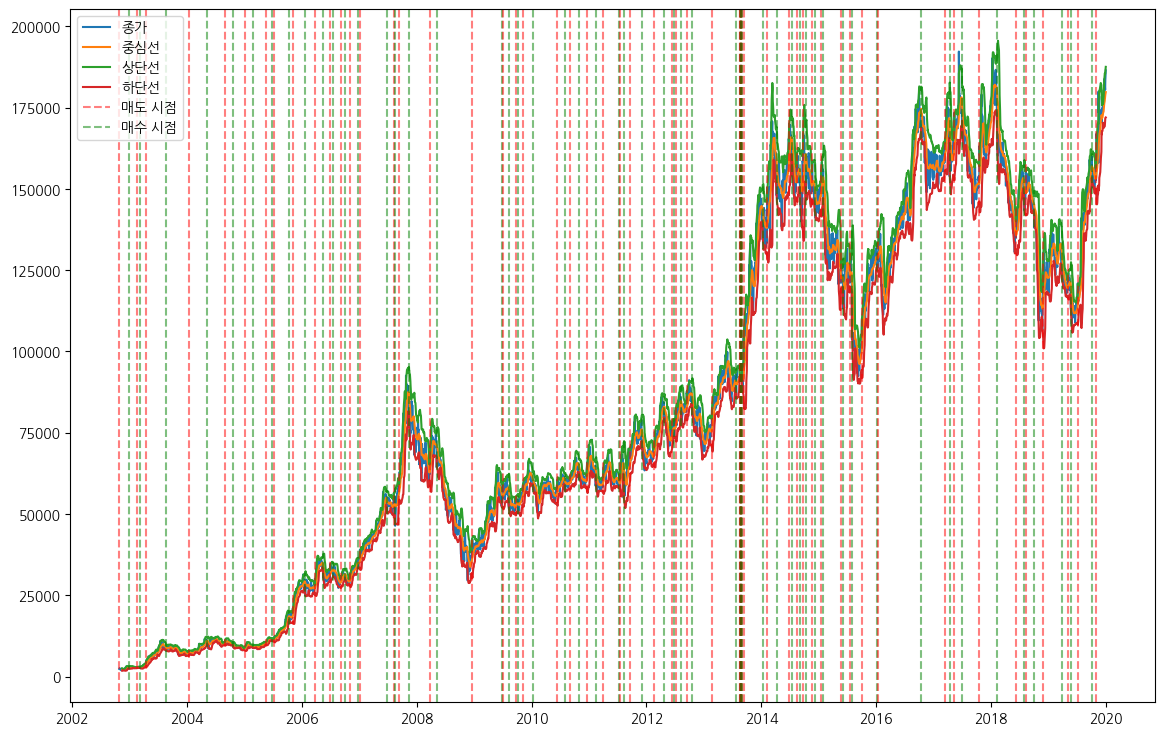

In [246]:
plt.figure(figsize=(14,9), dpi=100) # 
plt.plot(stock_df_close['종가'][:],label='종가')
plt.plot(stock_df_close['중심선'][:],label='중심선')
plt.plot(stock_df_close['상단선'][:],label='상단선')
plt.plot(stock_df_close['하단선'][:],label='하단선')
# Boolean 시리즈의 상태 변화 지점 찾기
bool_series = stock_df_close['bool'][:]
changes = bool_series.ne(bool_series.shift()).astype(int)  # 이전 값과 다른 지점 찾기
change_points = bool_series.index[changes == 1]  # 변화가 있는 지점의 인덱스

# 상태 변화 지점에 세로선 그리기
for idx in change_points:
    if bool_series[idx]:  # True로 변하는 지점
        plt.axvline(x=idx, color='g', linestyle='--', alpha=0.5, label='매수 시점' if '매수 시점' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:  # False로 변하는 지점
        plt.axvline(x=idx, color='r', linestyle='--', alpha=0.5, label='매도 시점' if '매도 시점' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.show()